<a href="https://colab.research.google.com/github/michiWS1920/nfl_data/blob/michi/playingaround.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
library(tidyverse)
library(ggplot2)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
install.packages("googledrive")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gargle’




In [ ]:
library(googledrive)

In [ ]:
chicken <- drive_upload(
  drive_example("chicken.csv"),
  "README-chicken.csv"

In [ ]:
first <- 2009 
last <- 2019 

datalist = list()
for (yr in first:last) {
    pbp <- read_csv(url(paste0("https://github.com/ryurko/nflscrapR-data/raw/master/play_by_play_data/regular_season/reg_pbp_", yr, ".csv"))) #read every play by play data
    games <- read_csv(url(paste0("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/games_data/regular_season/reg_games_", yr, ".csv"))) #read game data including score/ week etc.
    pbp <- pbp %>% 
      inner_join(games %>% distinct(game_id, week, season)) %>% #join the two
      select(-fumble_recovery_2_yards, -blocked_player_id, -fumble_recovery_2_player_id) # throw some variables out that are inconsistent in format over the seasons
    datalist[[yr]] <- pbp 
}

pbp_all <- dplyr::bind_rows(datalist)

In [ ]:
# Change teamnames for teams that changed their names in the last 10 seasons - to have consistent data
pbp_all <- pbp_all %>% 
	mutate_at(vars(home_team, away_team, posteam, defteam), funs(case_when(
            . %in% "JAX" ~ "JAC",
            . %in% "STL" ~ "LA",
            . %in% "SD" ~ "LAC",
            TRUE ~ .
        ))) 

In [1]:
#saveRDS(pbp_all, file="NFLdata.rds")
pbp_all <- readRDS("NFLdata.rds")

In [5]:
# cleaning for further analysis
pbp_all_rp <- pbp_all %>%
      filter(!is.na(epa), !is.na(posteam), play_type=="no_play" | play_type=="pass" | play_type=="run") %>% #filter out certain NA values, only show three play_types
	mutate( #create new columns that indicates if the play was a pass or rush - this is done by parsing the description of the play (certain keywords are perfect indicators)
	pass = if_else(str_detect(desc, "( pass)|(sacked)|(scramble)"), 1, 0), #
	rush = if_else(str_detect(desc, "(left end)|(left tackle)|(left guard)|(up the middle)|(right guard)|(right tackle)|(right end)") & pass == 0, 1, 0),
	success = ifelse(epa>0, 1 , 0),
	passer_player_name = ifelse(play_type == "no_play" & pass == 1, #create new column that parses the player_name depending on the type of play (pass / receiver / rusher)
              str_extract(desc, "(?<=\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?(?=\\s((pass)|(sack)|(scramble)))"),
              passer_player_name),
        receiver_player_name = ifelse(play_type == "no_play" & str_detect(desc, "pass"), 
              str_extract(desc, "(?<=to\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?"),
              receiver_player_name),
        rusher_player_name = ifelse(play_type == "no_play" & rush == 1, 
              str_extract(desc, "(?<=\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?(?=\\s((left end)|(left tackle)|(left guard)|		      (up the middle)|(right guard)|(right tackle)|(right end)))"),
              rusher_player_name),
	name = ifelse(!is.na(passer_player_name), passer_player_name, rusher_player_name),
	yards_gained=ifelse(play_type=="no_play",NA,yards_gained), # filter out NA for yards_gained
	play=1
	) #%>%
	#filter(pass==1 | rush==1) #only keep passes and rushes

In [15]:
pbp_all_rp %>%
select(play_type) %>%
head()

play_type
<chr>
pass
run
pass
run
pass
run


Problem is Timeouts are in noplay, have to filter them out


In [18]:
pbp_all_rp %>%
group_by(season) %>%
filter(play_type== "no_play", str_detect(desc, "(Timeout)")) %>%
select(desc)

Adding missing grouping variables: `season`



season,desc
<dbl>,<chr>
2009,Timeout #1 by PIT at 01:29.
2009,Timeout #1 by TEN at 00:54.
2009,Timeout #2 by PIT at 00:27.
2009,Timeout #3 by PIT at 00:07.
2009,Timeout #1 by PIT at 01:03.
2009,Timeout #2 by PIT at 00:44.
2009,Timeout #3 by PIT at 00:41.
2009,Timeout #1 by PIT at 10:34.
2009,Timeout #1 by CLE at 01:46.


In [27]:
pbp_all_rp %>%
group_by(season) %>%
filter(play_type == "no_play", !str_detect(desc, "(Timeout)")) %>%
#select(desc) %>%
count(season) -> pbp_all_flags
pbp_all_flags

season,n
<dbl>,<int>
2009,2215
2010,2326
2011,2459
2012,2445
2013,2276
2014,2527
2015,2632
2016,2584
2017,2482


In [32]:
pbp_all_rp %>%
group_by(season) %>%
filter(play_type == "no_play", !str_detect(desc, "(Timeout)"), str_detect(desc, "(Holding)")) %>%
select(desc) %>%
count(season)


Adding missing grouping variables: `season`



season,n
<dbl>,<int>
2009,414
2010,478
2011,508
2012,567
2013,521
2014,597
2015,680
2016,657
2017,609


NFL started to take holding much more seriously in later seasons. 

In [38]:
pbp_all_rp %>%
group_by(season) %>%
filter(play_type == "no_play", !str_detect(desc, "(Timeout)"), str_detect(desc, "(Mask)")) %>%
select(desc) %>%
count(season)

Adding missing grouping variables: `season`



season,n
<dbl>,<int>
2009,12
2010,12
2011,22
2012,10
2013,24
2014,27
2015,32
2016,47
2017,35


In [43]:
names(pbp_all_rp)

[1] "play_id"                             
  [2] "game_id"                             
  [3] "home_team"                           
  [4] "away_team"                           
  [5] "posteam"                             
  [6] "posteam_type"                        
  [7] "defteam"                             
  [8] "side_of_field"                       
  [9] "yardline_100"                        
 [10] "game_date"                           
 [11] "quarter_seconds_remaining"           
 [12] "half_seconds_remaining"              
 [13] "game_seconds_remaining"              
 [14] "game_half"                           
 [15] "quarter_end"                         
 [16] "drive"                               
 [17] "sp"                                  
 [18] "qtr"                                 
 [19] "down"                                
 [20] "goal_to_go"                          
 [21] "time"                                
 [22] "yrdln"                               
 [23] "ydstogo"                             
 [24] "ydsnet"                              
 [25] "desc"                                
 [26] "play_type"                           
 [27] "yards_gained"                        
 [28] "shotgun"                             
 [29] "no_huddle"                           
 [30] "qb_dropback"                         
 [31] "qb_kneel"                            
 [32] "qb_spike"                            
 [33] "qb_scramble"                         
 [34] "pass_length"                         
 [35] "pass_location"                       
 [36] "air_yards"                           
 [37] "yards_after_catch"                   
 [38] "run_location"                        
 [39] "run_gap"                             
 [40] "field_goal_result"                   
 [41] "kick_distance"                       
 [42] "extra_point_result"                  
 [43] "two_point_conv_result"               
 [44] "home_timeouts_remaining"             
 [45] "away_timeouts_remaining"             
 [46] "timeout"                             
 [47] "timeout_team"                        
 [48] "td_team"                             
 [49] "posteam_timeouts_remaining"          
 [50] "defteam_timeouts_remaining"          
 [51] "total_home_score"                    
 [52] "total_away_score"                    
 [53] "posteam_score"                       
 [54] "defteam_score"                       
 [55] "score_differential"                  
 [56] "posteam_score_post"                  
 [57] "defteam_score_post"                  
 [58] "score_differential_post"             
 [59] "no_score_prob"                       
 [60] "opp_fg_prob"                         
 [61] "opp_safety_prob"                     
 [62] "opp_td_prob"                         
 [63] "fg_prob"                             
 [64] "safety_prob"                         
 [65] "td_prob"                             
 [66] "extra_point_prob"                    
 [67] "two_point_conversion_prob"           
 [68] "ep"                                  
 [69] "epa"                                 
 [70] "total_home_epa"                      
 [71] "total_away_epa"                      
 [72] "total_home_rush_epa"                 
 [73] "total_away_rush_epa"                 
 [74] "total_home_pass_epa"                 
 [75] "total_away_pass_epa"                 
 [76] "air_epa"                             
 [77] "yac_epa"                             
 [78] "comp_air_epa"                        
 [79] "comp_yac_epa"                        
 [80] "total_home_comp_air_epa"             
 [81] "total_away_comp_air_epa"             
 [82] "total_home_comp_yac_epa"             
 [83] "total_away_comp_yac_epa"             
 [84] "total_home_raw_air_epa"              
 [85] "total_away_raw_air_epa"              
 [86] "total_home_raw_yac_epa"              
 [87] "total_away_raw_yac_epa"              
 [88] "wp"                                  
 [89] "def_wp"                            

In [57]:
pbp_all_rp %>%
group_by(season) %>%
filter(play_type == "no_play", !str_detect(desc, "(Timeout)")) %>%
select(desc, penalty_team) %>%
count(penalty_team) -> penalty_teams_per_season
penalty_teams_per_season

Adding missing grouping variables: `season`



season,penalty_team,n
<dbl>,<chr>,<int>
2009,ARI,79
2009,ATL,59
2009,BAL,83
2009,BUF,79
2009,CAR,64
2009,CHI,71
2009,CIN,92
2009,CLE,50
2009,DAL,95


In [56]:
pbp_all_rp <- pbp_all_rp %>% 
	mutate_at(vars(penalty_team), funs(case_when(
            . %in% "JAX" ~ "JAC",
            . %in% "STL" ~ "LA",
            . %in% "SD" ~ "LAC",
            TRUE ~ .
        ))) 

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


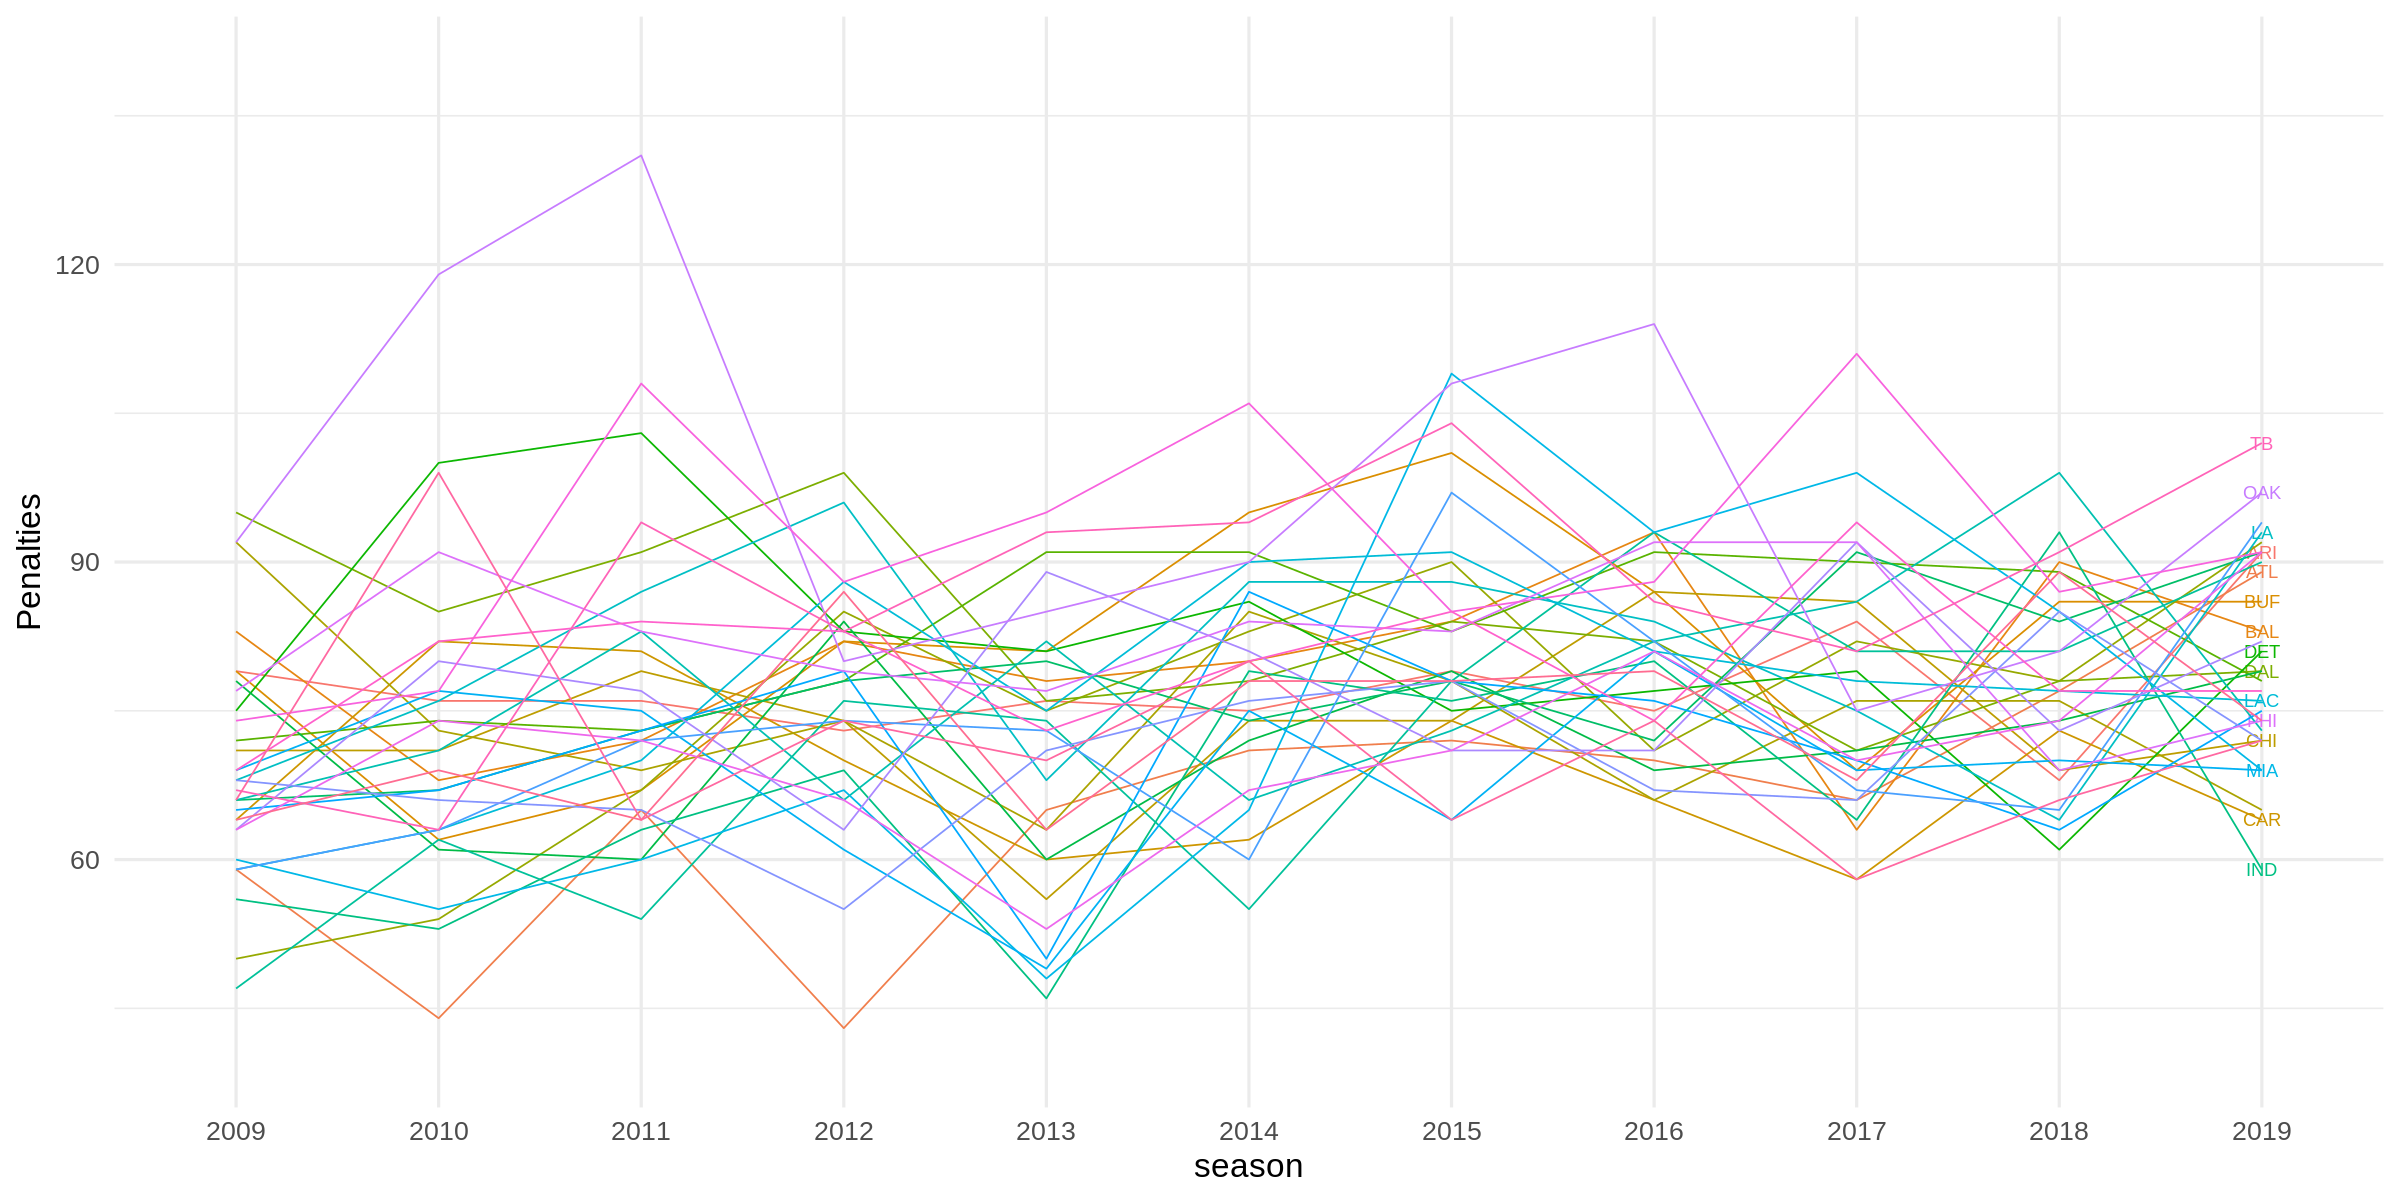

In [74]:
options(repr.plot.width=20, repr.plot.height=10)

penalty_teams_per_season %>%
group_by(penalty_team) %>%
ggplot(aes(x= season , y=n, color=penalty_team)) +
geom_text(data=penalty_teams_per_season %>% filter(season == 2019), aes(label=penalty_team), check_overlap = TRUE) +
geom_line() + 
xlim(2009, 2019) +
ylim(40, 140) +
labs(y = "Penalties") +
scale_x_discrete(limits= c(2009:2019))+
theme_minimal(base_size = 20) +
theme(legend.position = "none")

do same but with penalty_yards not just penalty_count